In [1]:
import cobra
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import json

from sklearn.decomposition import PCA

from amg_utils import amg_limits
from plotting_utils import plot_impact_graph

In [2]:
model = cobra.io.read_sbml_model("model_files/ProchlorococcusMED4+PHM2v1.xml")
amgs = json.loads(open("model_files/amg_reactions.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())
amg_gene_names = json.loads(open("model_files/amg_gene_map.json").read())
amg_rxn_names = {k: f"{v}: {k}" for k, v in amg_gene_names.items()}

In [3]:
with model as healthy:
    fva_healthy = cobra.flux_analysis.flux_variability_analysis(healthy)
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg = cobra.flux_analysis.flux_variability_analysis(phm2)
print(fva_healthy[fva_healthy.index == "BIOMASS"])
print(fva_healthy[fva_healthy.index == "PHM2_prodrxn_VN"])
print("-" * 80)
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "BIOMASS"])
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "PHM2_prodrxn_VN"])

          minimum   maximum
BIOMASS  0.098462  0.098462
                 minimum       maximum
PHM2_prodrxn_VN      0.0  1.418384e-12
--------------------------------------------------------------------------------
         minimum       maximum
BIOMASS      0.0 -3.601452e-13
                  minimum   maximum
PHM2_prodrxn_VN  0.183896  0.183896


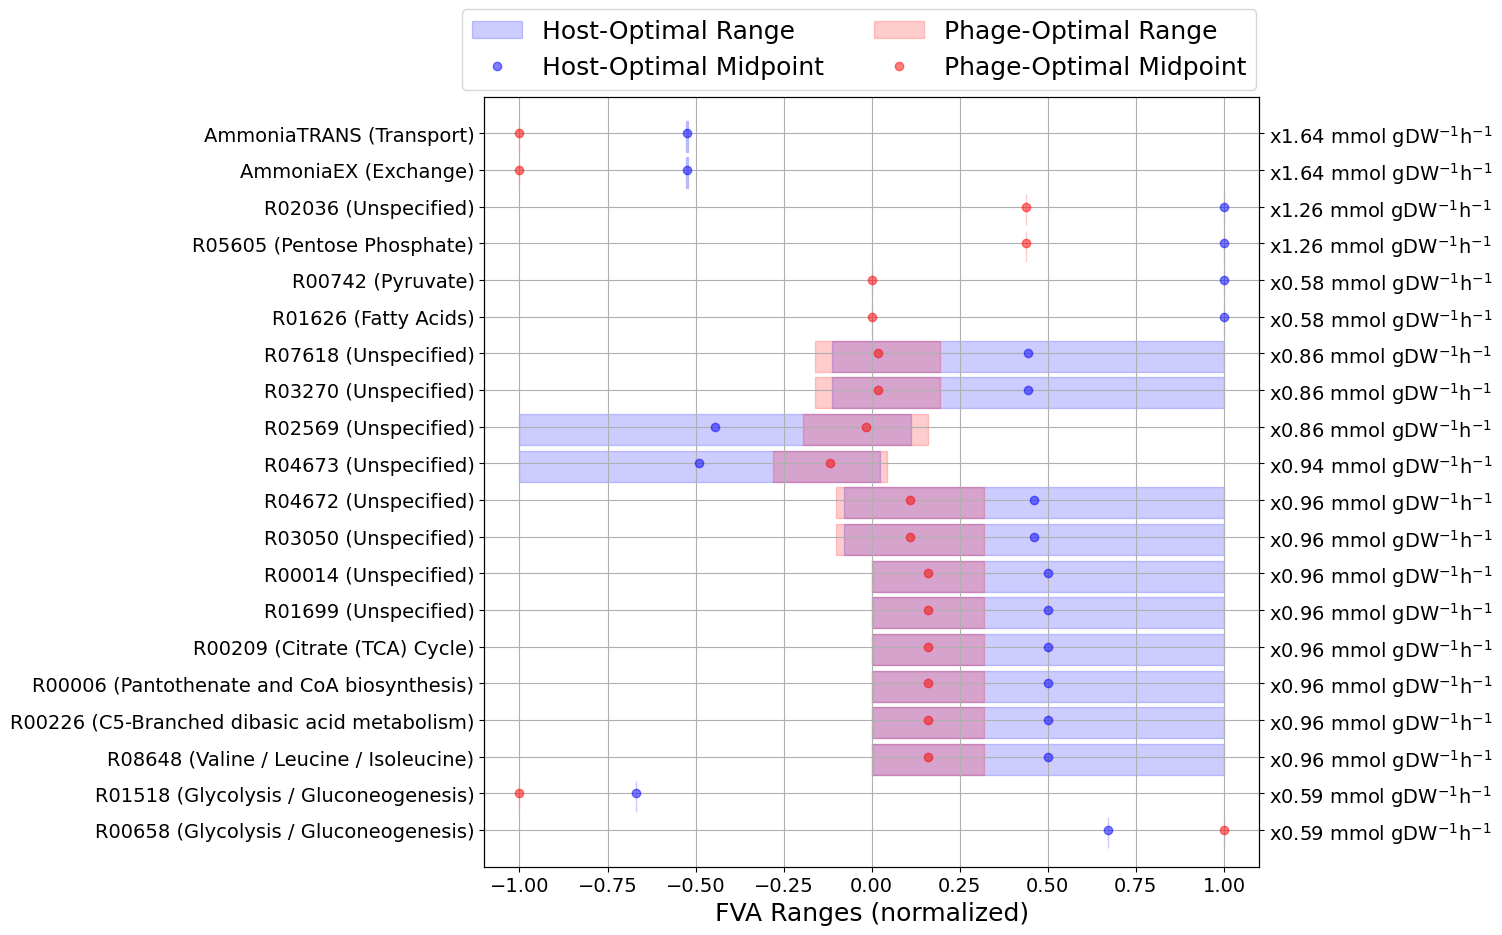

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_impact_graph(
    ax, model, fva_healthy, fva_phm2_no_amg, amgs, manual_relabels, cut=0.2
)
ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
fig.axes[1].tick_params(labelsize=14)
fig.legend(
    [
        "Host-Optimal Range",
        "Host-Optimal Midpoint",
        "Phage-Optimal Range",
        "Phage-Optimal Midpoint",
    ],
    ncols=2,
    loc="upper center",
    fontsize=18,
    bbox_to_anchor=(0.5, 0.98),
)
plt.show()

In [5]:
with model as healthy:
    fva_healthy_amg = cobra.flux_analysis.flux_variability_analysis(
        healthy, list(amgs.keys())
    )
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg_amg = cobra.flux_analysis.flux_variability_analysis(
        phm2, list(amgs.keys())
    )

In [6]:
# For some ridiculous reason, this is both faster and more numerically
# consistent that using the built-in reaction list feature...
h1 = {}
h2 = {}
i1 = {}
i2 = {}
for amg in amgs:
    with model as healthy:
        res = cobra.flux_analysis.flux_variability_analysis(
            healthy,
            [amg],
            fraction_of_optimum=0.5,
        )

    h1[amg] = res["minimum"][amg]
    h2[amg] = res["maximum"][amg]

    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        res = cobra.flux_analysis.flux_variability_analysis(
            phm2,
            [amg],
            fraction_of_optimum=0.5,
        )
    i1[amg] = res["minimum"][amg]
    i2[amg] = res["maximum"][amg]

h1 = {k: v for k, v in sorted(h1.items(), key=lambda x: amg_rxn_names[x[0]])}
h2 = {k: v for k, v in sorted(h2.items(), key=lambda x: amg_rxn_names[x[0]])}
i1 = {k: v for k, v in sorted(i1.items(), key=lambda x: amg_rxn_names[x[0]])}
i2 = {k: v for k, v in sorted(i2.items(), key=lambda x: amg_rxn_names[x[0]])}

fva_healthy_amg2 = pd.DataFrame({"minimum": h1, "maximum": h2})
fva_phm2_amg2 = pd.DataFrame({"minimum": i1, "maximum": i2})

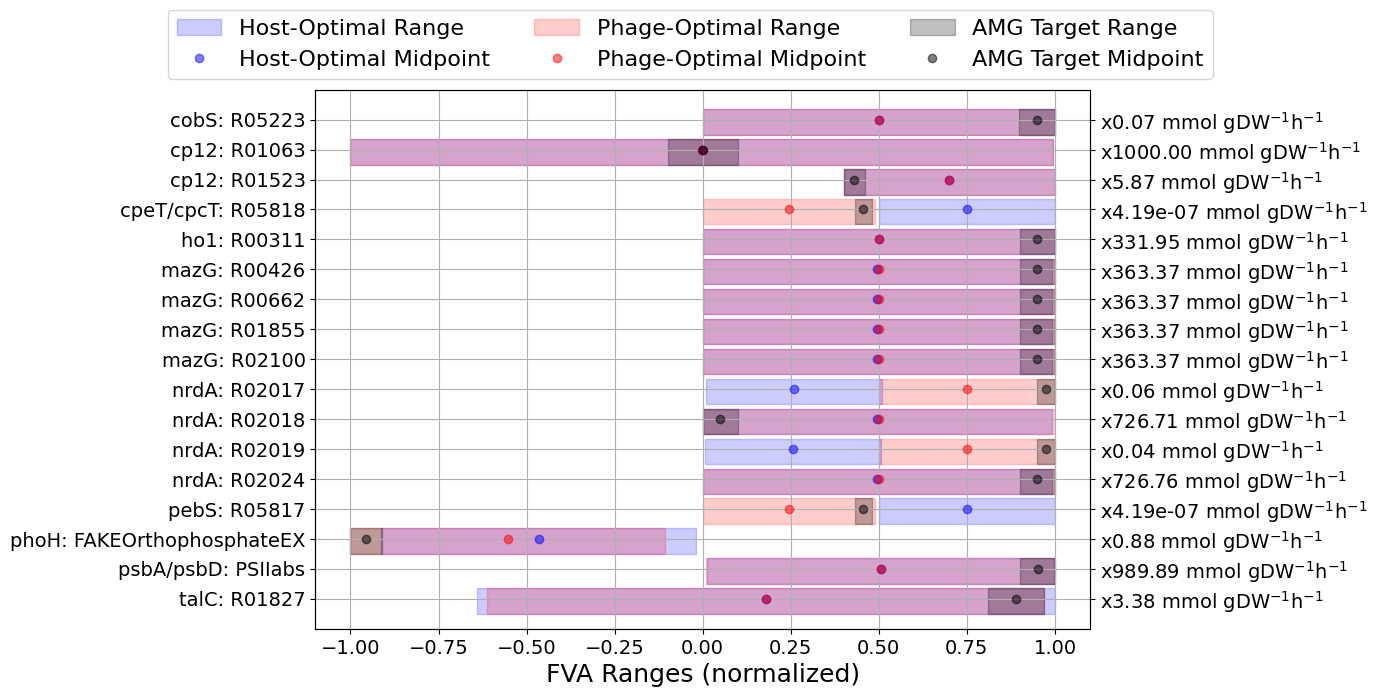

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
highlights = {}
for i, (amg, direction) in enumerate(amgs.items()):
    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        lb, ub = amg_limits(phm2, amg, direction, optimum_fraction=0.5, tol=0.1)
    highlights[amg] = (lb, ub)
plot_impact_graph(
    ax,
    model,
    fva_healthy_amg2,
    fva_phm2_amg2,
    [],
    manual_relabels,
    cut=0,
    sort=False,
    highlights=highlights,
)
# ax.set_ylim(-11, 1.3)

ax.set_yticklabels(sorted(amg_rxn_names.values()))

ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
fig.axes[1].tick_params(labelsize=14)
# ax.set_title("Biomass Lax Optimization Impact on AMG-Hijacked Reactions", fontsize=22)
fig.legend(
    [
        "Host-Optimal Range",
        "Host-Optimal Midpoint",
        "Phage-Optimal Range",
        "Phage-Optimal Midpoint",
        "AMG Target Range",
        "AMG Target Midpoint",
    ],
    ncols=3,
    loc="upper center",
    fontsize=16,
    bbox_to_anchor=(0.5, 1.01),
)
plt.show()

In [8]:
amg_new_vals = {}
for amg, direction in amgs.items():
    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        lb, ub = amg_limits(phm2, amg, direction, optimum_fraction=0.5, tol=0.1)
    amg_new_vals[amg] = (lb + ub) / 2
amg_new_vals

{'FAKEOrthophosphateEX': np.float64(-0.8378580935670241),
 'PSIIabs': np.float64(940.8959434104111),
 'R00311': np.float64(315.35381478701333),
 'R00426': np.float64(345.2020865248845),
 'R00662': np.float64(345.20208652488446),
 'R01063': np.float64(0.0),
 'R01523': np.float64(2.5262500000001102),
 'R01827': np.float64(3.012405245444948),
 'R01855': np.float64(345.2020865248836),
 'R02017': np.float64(0.05653061276502651),
 'R02018': np.float64(36.07307168163051),
 'R02019': np.float64(0.03481750597014656),
 'R02024': np.float64(690.4220281811291),
 'R02100': np.float64(345.2020865248846),
 'R05223': np.float64(0.07087301587301495),
 'R05817': np.float64(1.9110132487691267e-07),
 'R05818': np.float64(1.911013248769127e-07)}

In [9]:
amg_fvas = {}
for amg, new_val in amg_new_vals.items():
    with model as phm2:
        phm2.reactions.get_by_id(amg).bounds = new_val, new_val
        fva_phm2 = cobra.flux_analysis.flux_variability_analysis(phm2)
    amg_fvas[amg] = fva_phm2.copy()


In [10]:
hmid = (fva_healthy["maximum"] + fva_healthy["minimum"]) / 2
mdiffs = {}
for amg, fva in sorted(amg_fvas.items()):
    mids = (fva["maximum"] + fva["minimum"]) / 2
    mid_diff = mids - hmid
    mdiffs[amg] = mid_diff
mdf = pd.DataFrame(mdiffs)

In [11]:
mdf = mdf.reindex(sorted(mdf.columns, key=lambda x: amg_rxn_names[x]), axis=1)
mdf

,R05223,R01063,R01523,R05818,R00311,R00426,R00662,R01855,R02100,R02017,R02018,R02019,R02024,R05817,FAKEOrthophosphateEX,PSIIabs,R01827
R01055,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
R00546,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
R05605,-5.980019e-01,-2.220446e-15,-5.829068e-01,-0.333912,-3.067524e-11,-3.543832e-13,9.916512e-13,-2.304823e-13,-6.421530e-13,-0.691819,-4.318768e-13,-0.691892,2.483125e-12,-0.333912,-6.613787e-01,-4.773959e-14,-4.518912e-01
R00346,2.416372e+00,6.536993e-12,1.154206e+01,13.569983,-1.254953e+02,-1.726010e+02,-1.726010e+02,-1.726010e+02,-1.726010e+02,5.938918,-1.803703e+01,5.939546,-3.452108e+02,13.569983,4.669058e+00,-2.834389e+02,6.420077e+00
R00355,5.622902e-01,-4.689582e-13,2.566579e+00,3.003862,3.974776e-11,-1.178342e+02,-1.178342e+02,-1.178342e+02,-1.178342e+02,1.064450,2.273737e-13,1.064563,-1.178387e+02,3.003862,3.464795e-02,-1.102262e+02,1.989708e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R01078,0.000000e+00,1.678784e-13,0.000000e+00,0.000000,0.000000e+00,1.333081e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Trans_H2O2,-5.197541e-03,-4.902745e-11,-5.066342e-03,-0.005956,9.760743e+01,-2.781197e-11,-7.297674e-11,-1.056422e-10,-2.716716e-12,-0.010676,-5.782397e-11,-0.010677,-6.391643e-11,-0.005956,-5.748382e-03,-1.967670e-11,-3.927618e-03
H2O2EX,-5.197541e-03,-6.603784e-11,-5.066342e-03,-0.005956,9.760743e+01,-7.779777e-11,-9.178680e-11,-1.488747e-10,1.072253e-11,-0.010676,-6.026823e-11,-0.010677,-1.280325e-10,-0.005956,-5.748382e-03,-2.211564e-11,-3.927618e-03
R02036,-5.980019e-01,-2.193246e-11,-5.829068e-01,-0.333912,-4.753531e-11,-1.987166e-11,-1.993516e-11,-3.521561e-11,-9.065193e-12,-0.691819,-1.429457e-11,-0.691892,-2.541123e-11,-0.333912,-6.613787e-01,-1.021161e-11,-4.518912e-01


In [12]:
mdf_filtered = mdf[mdf.abs().max(axis=1) >= 0.25].apply(lambda x: x)
mdf_filtered["Phage Biomass"] = (
    fva_phm2_no_amg["maximum"] + fva_phm2_no_amg["minimum"]
) / 2 - hmid

mdf_filtered = mdf_filtered.sort_index(
    axis=0,
    key=lambda x: [model.reactions.get_by_id(y).subsystem for y in x],
)
last = ""
switch_inds = [(0, "Unspecified")]
for i, (rxn, row) in enumerate(mdf_filtered.iterrows()):
    ss = model.reactions.get_by_id(rxn).subsystem
    if last != ss:
        last = ss
        if ss in manual_relabels:
            ss = manual_relabels[ss]
        switch_inds.append((i, ss))

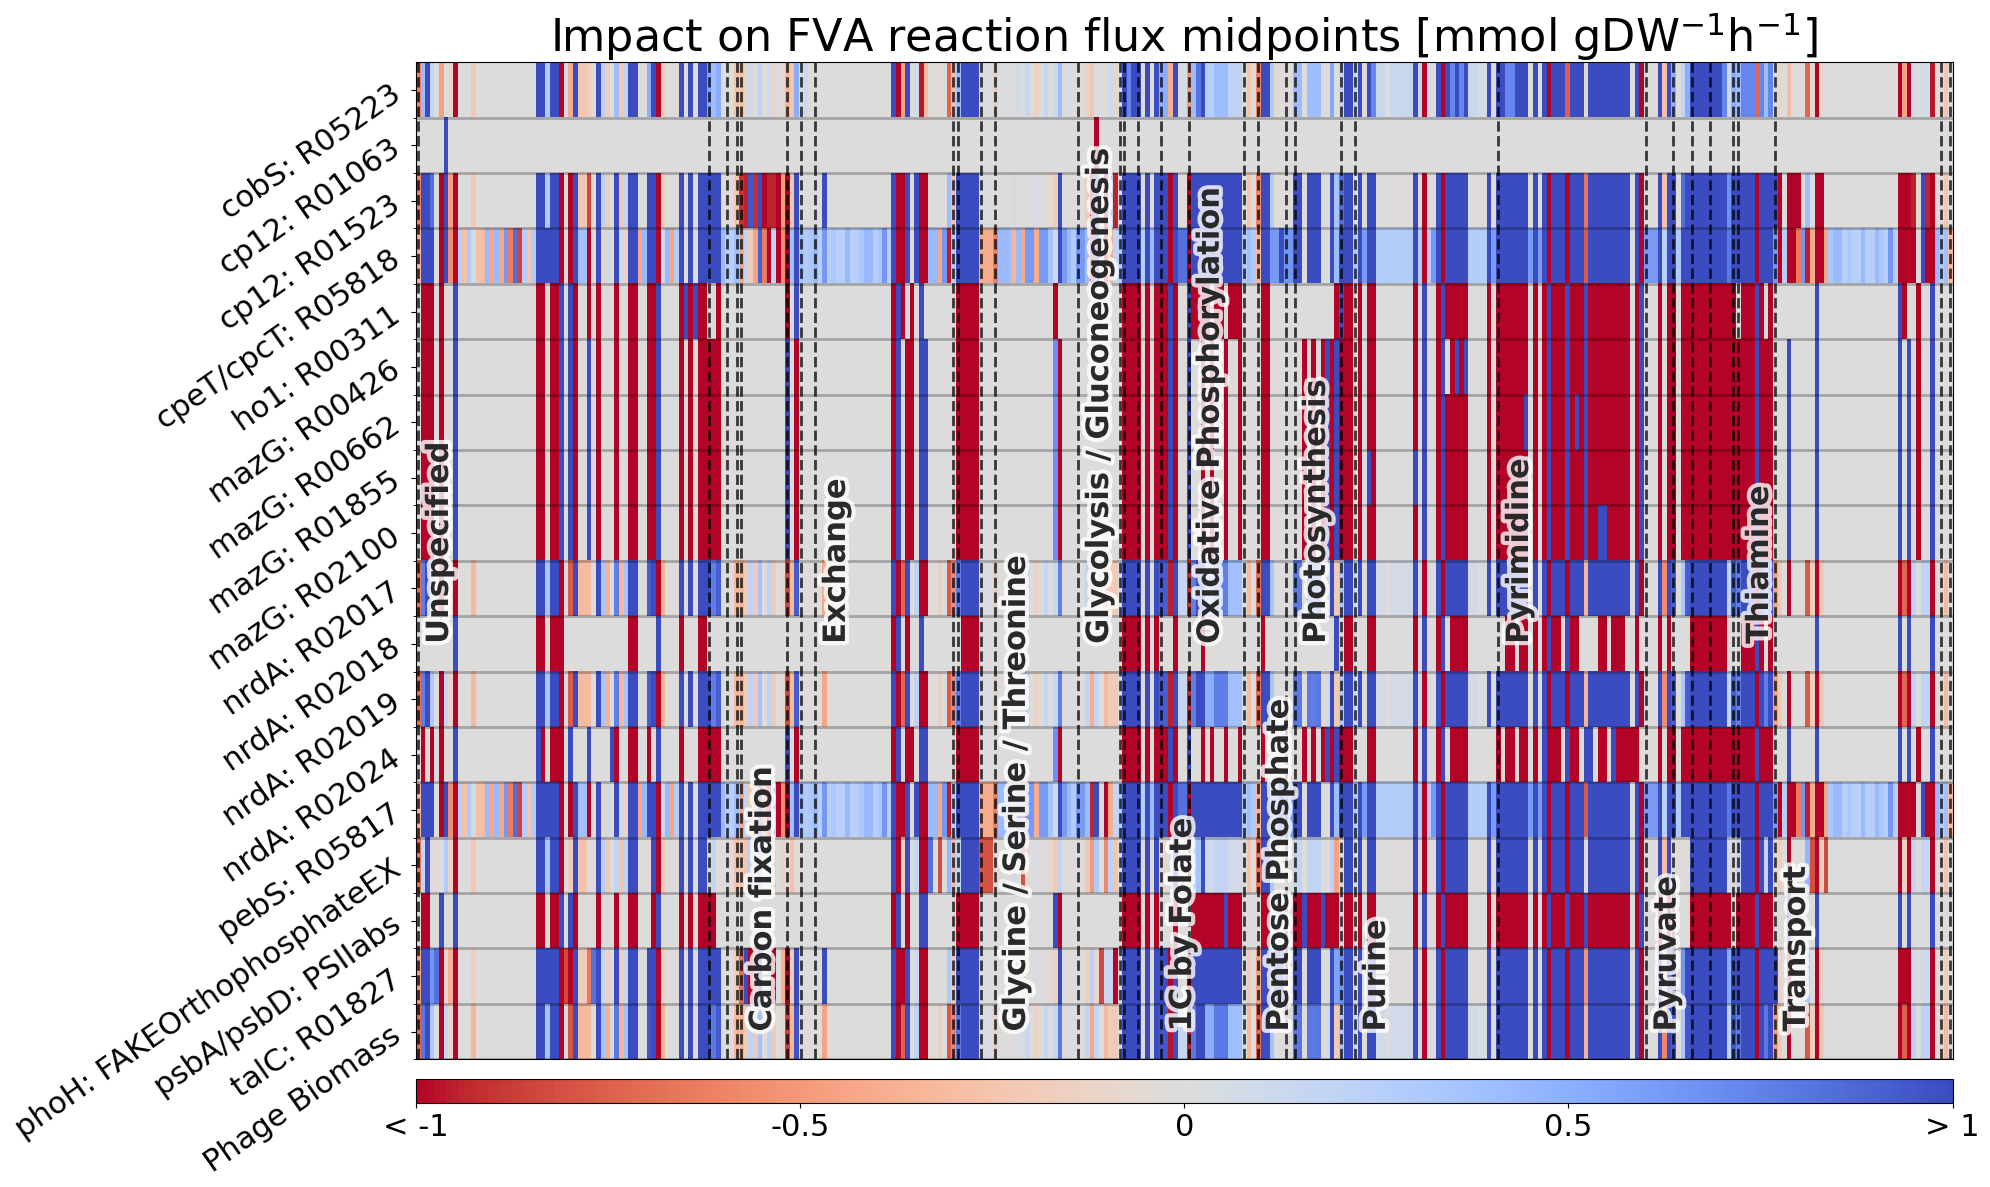

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.matshow(
    mdf_filtered.T,
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1,
    aspect=12,
    interpolation="none",
)
ticks = range(1 + len(sorted(amgs.keys())))

ax.set_yticks(ticks, minor=False)
ax.set_yticks([0.5 + x for x in ticks], minor=True)
ax.set_yticklabels(
    sorted(amg_rxn_names.values()) + ["Phage Biomass"], fontsize=22, rotation=35
)
ax.set_xticks([])
ax.grid(True, which="minor", alpha=0.25, color="black", linewidth=2)
ax.set_title(
    "Impact on FVA reaction flux midpoints " + r"[mmol gDW$^{-1}$h$^{-1}$]", fontsize=32
)
cbar = fig.colorbar(
    im,
    aspect=64,
    orientation="horizontal",
    pad=0.01,
)
cbar.set_ticks(
    ticks=[-1, -0.5, 0, 0.5, 1],
    labels=["< -1", "-0.5", "0", "0.5", "> 1"],
    fontsize=22,
)

offset = -3.5
for line, (i, ss) in enumerate(switch_inds):
    if ss == "":
        ss = "Unspecified"
    ax.vlines(
        i,
        -0.5,
        len(amgs) + 0.5,
        linestyles="dashed",
        color="black",
        alpha=0.75,
        linewidth=2,
    )
    if (line < len(switch_inds) - 1) and switch_inds[line + 1][0] - i > 5:
        ax.text(
            i + 1.5,
            len(amgs) - abs(offset) + offset,
            ss,
            horizontalalignment="left",
            verticalalignment="bottom",
            fontsize=22,
            fontweight="bold",
            rotation=90,
            color="black",
            alpha=0.8,
            backgroundcolor="#c0c0c000",
            path_effects=[pe.withStroke(linewidth=6, foreground="#ffffff", alpha=0.8)],
        )
        offset *= -1


fig.tight_layout()
# fig.savefig("phage_barcode.png")
plt.show()

In [14]:
pcadf = pd.concat([mdf.iloc[:, 0] * 0, mdf], axis=1)
pcadf.columns = ["No AMG"] + list(mdf.columns)
pcadf.drop("No AMG", axis=1, inplace=True)
df_normalized = ((pcadf - pcadf.mean()) / pcadf.std()).fillna(0)

pca = PCA(n_components=pcadf.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC%s" % _ for _ in range(len(df_normalized.columns))],
    index=pcadf.columns,
)
loadings.reindex(sorted(loadings.index, key=lambda x: amg_rxn_names[x]))
loadings

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
R05223,2.719183e-01,-3.964522e-03,-3.426859e-12,5.288629e-02,1.325816e-01,-2.860025e-02,1.738315e-01,1.919215e-01,-9.640221e-03,-1.055523e-03,4.148966e-02,6.150637e-01,-4.447756e-01,1.445234e-01,-4.888451e-01,-6.316382e-08,4.628157e-09
R01063,-5.695777e-12,-1.776713e-10,1.000000e+00,6.096865e-12,4.531792e-13,1.212202e-11,4.987621e-12,1.044928e-12,-4.065862e-13,2.684301e-13,8.514283e-13,3.077594e-12,-9.543755e-13,3.567285e-13,-1.554784e-12,-8.061338e-13,3.939941e-14
R01523,2.725596e-01,-7.689039e-03,4.683476e-13,5.879678e-02,1.341851e-01,-1.716857e-02,6.835711e-02,3.481693e-02,-2.601975e-04,1.289073e-03,2.078398e-01,-4.460940e-01,-1.657082e-01,7.892362e-01,7.387682e-02,-5.482415e-09,4.028702e-10
R05818,2.730276e-01,-7.142597e-03,3.446132e-13,5.352217e-02,1.334839e-01,-1.343735e-02,6.430511e-02,1.684044e-02,3.297185e-03,4.794705e-03,2.189168e-01,-3.477526e-01,-2.093135e-01,-4.139398e-01,-1.267851e-01,-5.165100e-02,-7.052178e-01
R00311,-1.465174e-01,-9.898199e-02,-2.522701e-11,9.604044e-01,-1.876591e-01,7.875428e-02,-2.210273e-03,-1.664004e-02,1.155325e-03,5.490752e-04,6.207054e-02,1.317288e-02,-2.470195e-02,-1.843277e-03,4.131595e-03,7.321151e-09,-5.359886e-10
R00426,-2.650929e-01,-4.027219e-03,3.002765e-12,8.789786e-03,4.650682e-02,-4.272185e-01,-1.662641e-01,8.219634e-01,-9.340174e-02,1.503550e-03,1.560254e-01,-7.095002e-02,3.478839e-02,-2.598185e-02,4.119441e-02,-4.967301e-11,3.026850e-12
R00662,-2.619282e-01,-1.051249e-02,-1.880551e-12,3.357657e-02,3.120929e-01,-2.170679e-01,2.398848e-01,-7.739419e-02,8.488913e-01,-3.382239e-05,3.787067e-02,-1.767198e-03,1.542410e-03,2.900611e-03,-6.013685e-03,-5.037902e-09,3.691906e-10
R01855,-2.615205e-01,-6.461193e-03,-1.783906e-12,3.528869e-02,3.155570e-01,-2.383497e-01,3.038556e-01,-2.140263e-01,-3.660669e-01,7.074716e-01,3.530092e-02,3.503960e-03,-2.446976e-03,2.978845e-03,-1.845406e-03,-8.112516e-09,5.942705e-10
R02100,-2.615275e-01,-6.458957e-03,-1.400380e-12,3.526328e-02,3.154613e-01,-2.383143e-01,3.033826e-01,-2.143071e-01,-3.665265e-01,-7.066697e-01,4.772796e-02,-1.413172e-03,-5.076800e-03,-1.128134e-03,-3.049469e-03,-8.096960e-09,5.931084e-10
R02017,2.724790e-01,-1.530060e-02,-1.841860e-12,7.312376e-02,1.397199e-01,3.460787e-03,1.988093e-01,1.350262e-01,-2.427879e-03,-2.063440e-03,-1.442947e-01,1.611201e-01,-5.232139e-02,-7.862864e-02,5.358845e-01,7.052180e-01,-5.165087e-02


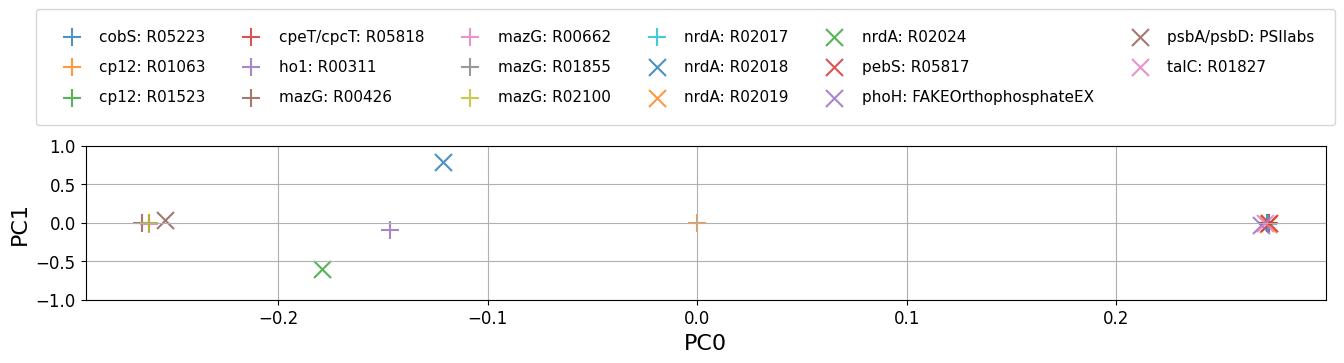

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 2))
for i, (amg, row) in enumerate(loadings.iterrows()):
    x = row["PC0"]
    y = row["PC1"]
    if amg == "No AMG":
        continue
    ax.scatter(
        x,
        y,
        label=amg_rxn_names[amg],
        marker="+" if i < 10 else "x",
        s=150,
        alpha=0.8,
    )
ax.grid(True)
ax.tick_params(axis="both", which="both", labelsize=12)
ax.set_xlabel("PC0", fontsize=16)
ax.set_ylabel("PC1", fontsize=16)
fig.legend(
    ncols=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.6),
    fontsize=11,
    labelspacing=1,
    borderpad=1.3,
)
# ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.show()